# Using RNN and TF-IDF to analyse tweets

# RNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
whole_df = pd.read_csv('tweet_train.csv', encoding='latin', header=None, names=[
    'attitude', 'id', 'date', 'flag', 'user', 'text'
])

In [38]:
whole_df.head(3)

,attitude,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


<AxesSubplot:>

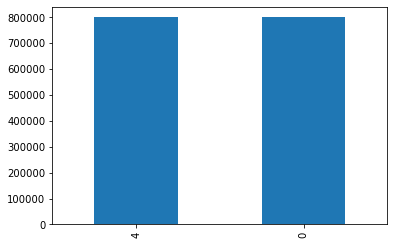

In [15]:
whole_df.attitude.value_counts().plot.bar()

In [16]:
whole_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   attitude  1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   flag      1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [3]:
# Because the computer resource limitation, only choose 10,000 tweets randomly
df = whole_df.copy().sample(10000, random_state=100)
df = df.drop(columns=['id', 'date', 'flag', 'user'])

In [4]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
# Read in and clean data
import nltk
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import string

stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

df['clean_text'] = df['text'].apply(lambda x: clean_text(x))
df.head()

,attitude,text,clean_text
883393,4,@nicholasmw 1 day u will find that girl worry,"[nicholasmw, 1, day, u, find, girl, worry, ]"
461479,0,there is nothing on tv and im so desperate to ...,"[nothing, tv, im, desperate, entertained, im, ..."
103630,0,Very excited that greys is on tonight. Not so ...,"[excited, greys, tonight, happy, season, ]"
1031265,4,2pm's again and again is a great song. Nichkhu...,"[2pms, great, song, nichkhun, hwaiting, ]"
219956,0,My teeth hurt,"[teeth, hurt, ]"


In [6]:
# Label the attitude column
df['attitude'] = np.where(df['attitude']==4, 1, 0)

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'],
                                                    df['attitude'], test_size=0.2)

In [86]:
df.attitude.value_counts()

0    5055
1    4945
Name: attitude, dtype: int64

In [7]:
# Train the tokenizer and use that tokenizer to convert the sentences to sequences of numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [8]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

# Recurrent Neural Network 

In [102]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [103]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          539936    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 549,345
Trainable params: 549,345
Non-trainable params: 0
_________________________________________________________________


In [104]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [105]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
250/250 [==============================] - 22s 89ms/step - loss: 0.6252 - accuracy: 0.6421 - precision_m: 0.6450 - recall_m: 0.6668 - val_loss: 0.5211 - val_accuracy: 0.7475 - val_precision_m: 0.7403 - val_recall_m: 0.7673
Epoch 2/10
250/250 [==============================] - 21s 84ms/step - loss: 0.3673 - accuracy: 0.8461 - precision_m: 0.8462 - recall_m: 0.8446 - val_loss: 0.5623 - val_accuracy: 0.7480 - val_precision_m: 0.7455 - val_recall_m: 0.7534
Epoch 3/10
250/250 [==============================] - 21s 82ms/step - loss: 0.1753 - accuracy: 0.9351 - precision_m: 0.9393 - recall_m: 0.9298 - val_loss: 0.7165 - val_accuracy: 0.7240 - val_precision_m: 0.7333 - val_recall_m: 0.7008
Epoch 4/10
250/250 [==============================] - 21s 86ms/step - loss: 0.0851 - accuracy: 0.9706 - precision_m: 0.9722 - recall_m: 0.9695 - val_loss: 0.8609 - val_accuracy: 0.7120 - val_precision_m: 0.7346 - val_recall_m: 0.6671
Epoch 5/10
250/250 [==============================] - 21s 84ms/s

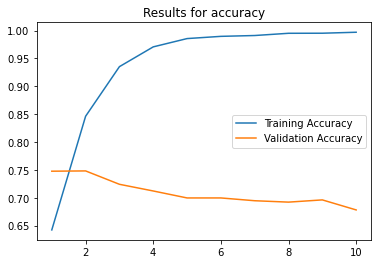

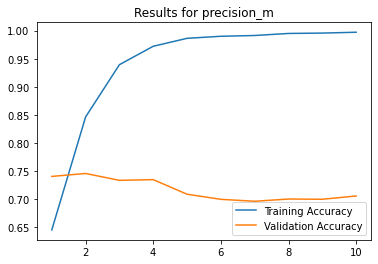

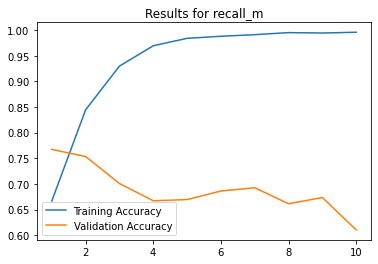

In [106]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

# Using TF-IDF

In [9]:
# Load the cleaned training and test sets
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate and fit a TFIDF vectorizer and then use that trained vectorizer
# to transform the messages in the training and test sets
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train.apply(lambda x: ' '.join(x)))
X_train_vect = tfidf_vect.transform(X_train.apply(lambda x: ' '.join(x)))
X_test_vect = tfidf_vect.transform(X_test.apply(lambda x: ' '.join(x)))

In [10]:
# Fit a basic Random Forest model on these vectors
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect, y_train.values.ravel())

In [11]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect)

In [12]:
# Evaluate the predictions of the model on the holdout test set
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accurate = accuracy_score(y_test, y_pred)
print('Precision: ', precision)
print('recall: ', recall)
print('recall: ', accurate)

Precision:  0.6869479882237488
recall:  0.7172131147540983
recall:  0.7025


# Modeling Conclusion

#### While improving the accuracy, we use the TF-IDF model to analyse tweet sentiment

# Model Implementation

In [15]:
# load the retrieved tweets
retrieved_tweets = pd.read_csv('retrieved_tweet.csv')
retrieved_tweets.head(3)

,text,clean_text
0,Tempus is on IWG and Abcam\nhttps://t.co/CynbF...,"['tempus', 'iwg', 'abcam', 'httpstcocynbfio3mg']"
1,RT @smallcappick: The Times (Tempus share tips...,"['rt', 'smallcappick', 'times', 'tempus', 'sha..."
2,A huge thanks again to our sponsors and to our...,"['huge', 'thanks', 'sponsors', 'attendees', 'v..."


In [19]:
# Tokenize the retrieved tweets into words, then padding
tokenizer.fit_on_texts(retrieved_tweets['clean_text'])
tokenized_tweet = tokenizer.texts_to_sequences(retrieved_tweets['clean_text'])
padded_tweet_seq = pad_sequences(tokenized_tweet, 50)

In [36]:
# Vectorize the sequences
tfidf_vect.fit(retrieved_tweets['clean_text'].values.ravel())
tweet_vec = tfidf_vect.transform(retrieved_tweets['clean_text'].values.ravel())

In [37]:
tweet_vec[0].toarray()

array([[0.        , 0.37869177, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.63772057, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.47429159, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.47429159, 0.  

In [38]:
predicted_tweet = rf_model.predict(tweet_vec)

ValueError: Number of features of the model must match the input. Model n_features is 16788 and input n_features is 83 